In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Генерация сигналов

In [41]:
SIZE_TS = 50
NUMB_TS = 10

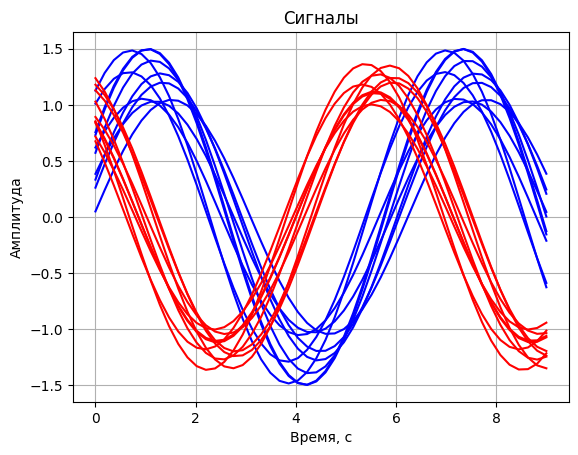

In [85]:
#  индекс и отсчет времени в секундах
time = np.linspace(0, 9, SIZE_TS)

tseries_list = {'Time': time}

serieses = []
lables = [0] * 10
lables.extend([1] * 10)

for i in range(NUMB_TS):
    temp_sin = random.uniform(1, 1.5) * np.sin(time +  random.uniform(0, 1))
    tseries_list["Tsin" + str(i)] = temp_sin
    serieses.append(temp_sin)

for i in range(NUMB_TS):
    temp_cos = random.uniform(1, 1.4) * np.cos(time + random.uniform(0.2, 1))
    tseries_list["Tcos" + str(i)] = temp_cos
    serieses.append(temp_sin)

# отрисовка всех сигналов
for i in range(NUMB_TS):
    plt.plot(time, tseries_list["Tsin"+str(i)], '-b')
for i in range(NUMB_TS):
    plt.plot(time, tseries_list["Tcos"+str(i)], '-r')
    
plt.title('Сигналы')
plt.ylabel('Амплитуда')
plt.xlabel('Время, с')
plt.grid()

## Shapelet

In [86]:
def normilize(R):
    m = np.mean(R)
    s = np.std(R)
    if s > 0.00001:
        res = (R-m)/s
    else:
        res = R - m
    return res

def dist(R,L):
    R = normilize(R)
    L = normilize(L)
    S = R - L
    S = S*S
    res = np.sum(S)
    return res

def extract_subsequnces(T,L):
    res = []
    for i in range(len(T)-L+1):
        res.append(T[i:i+L])
    return res

def dist_series(R,T):
    W = extract_subsequnces(T,len(R))
    d = np.zeros(len(W))
    for i,j in enumerate(W):
        d[i] = dist(R,j)
    res = np.min(d)
    return res

def entropy(T):
    n = len(T)
    if n != 0:
        ones = np.sum(T)
        zeros = n - ones
        res = 0
        if zeros != 0:
            res += -zeros/n*np.log(zeros/n)
        if ones != 0:
            res += -ones/n*np.log(ones/n)
    else:
        res = 0
    return res

def calc_quality(Ds,lables):
    temp = list(zip(Ds,lables))
    temp = sorted(temp,key=lambda x: x[0])
    labels = np.array([i[1] for i in temp])
    igs = np.zeros(len(labels))
    base = entropy(labels)
    n = len(labels)
    for i,j in enumerate(temp):
        igs[i] = base - (i/n*entropy(labels[:i]) + (n-i)/n*entropy(labels[i:]))
    res = np.max(igs)
    return res

def remove_similar(shapelets):
    flags = [True]*len(shapelets)
    for i in range(len(shapelets)):
        for j in range(i+1,len(shapelets)):
            if dist(shapelets[i][0],shapelets[j][0]) < 0.00001:
                flags[i] = False
                break
    for i in range(len(flags)-1,-1,-1):
        if not flags[i]:
            shapelets.pop(i)
    return shapelets

def remove_similar_2(shapelets):
    flags = [True]*len(shapelets)
    for i in range(len(shapelets)):
        for j in range(i+1,len(shapelets)):
            if dist(shapelets[i],shapelets[j]) < 0.00001:
                flags[i] = False
                break
    for i in range(len(flags)-1,-1,-1):
        if not flags[i]:
            shapelets.pop(i)
    return shapelets

def remove_similar_between_lists_2(shapelets,new_shapelets):
    flags = [True]*len(new_shapelets)
    for i in range(len(new_shapelets)):
        for j in range(len(shapelets)):
            if dist(new_shapelets[i],shapelets[j]) < 0.00001:
                flags[i] = False
                break
    for i in range(len(flags)-1,-1,-1):
        if not flags[i]:
            new_shapelets.pop(i)
    return new_shapelets

def add_if_new(shapelets,shap):
    flag = True
    for j in range(len(shapelets)):
            if dist(shap[0],shapelets[j][0]) < 0.0000001:
                flag = False
                break
    if flag:
         shapelets.append(shap)
    return flag

In [87]:
dataset = list(zip(serieses,lables))

random.seed(42)
random.shuffle(dataset)

train = dataset[:16]
test = dataset[16:]

train_serieses = [i[0] for i in train]
train_labels = [i[1] for i in train]
test_serieses = [i[0] for i in test]
test_labels = [i[1] for i in test]

origin_serieses = serieses
origin_lables = lables
serieses = train_serieses
lables = train_labels

In [88]:
#Ограничения длины шапилетов
min_len = 5
max_len = 25

#Кол-во шапелетов, которое достается из каждого обучающего ряда
p = 5

#найденные шапелеты по длинам
rShapeles = {}
for i in range(min_len,max_len+1):
    rShapeles[i] = []

for d,i in enumerate(serieses):
    print(f"{d+1}/{len(serieses)}")
    shapelets = []
    #Достаем все шапелеты из ряда и оцениваем их
    for j in range(min_len,max_len+1):
        sh_same_lenght = []
        W = extract_subsequnces(i,j)
        for k in W:
            Ds = np.zeros(len(serieses))
            for z,f in enumerate(serieses):
                Ds[z] = dist_series(k,f)
            quality = calc_quality(Ds,lables)
            sh_same_lenght.append((k,quality))
        #Удаляем потворы
        sh_same_lenght = remove_similar(sh_same_lenght)
        shapelets.extend(sh_same_lenght)
    #Сортируем шапелеты по качеству и добавляем только p лучших (если они уже не добавлены из прошлых рядов)
    shapelets = sorted(shapelets,key=lambda x: x[1],reverse=True)
    s = 0
    j = 0
    while j < len(shapelets) and s < p:
        if add_if_new(rShapeles[len(shapelets[j][0])],shapelets[j]):
            s += 1
        j += 1

SH = list(rShapeles.values())

1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
16/16


In [89]:
SH = []
qualities = []

for i in rShapeles.keys():
    for j in rShapeles[i]:
        SH.append(j[0])
        qualities.append(j[1])

In [90]:
def constract_features_vector(T,shapelets):
    D = np.zeros(len(shapelets))
    for i in range(len(shapelets)):
        D[i] = dist_series(shapelets[i],T)
    return D

train_features = [constract_features_vector(i,SH) for i in train_serieses]
test_features = [constract_features_vector(i,SH) for i in test_serieses]

In [91]:
clf = RandomForestClassifier(30)
clf.fit(train_features,train_labels)

RandomForestClassifier(n_estimators=30)

#### Итоги обучения

In [92]:
print(f"Train accuracy={clf.score(train_features,train_labels)}")
print(f"test accuracy={clf.score(test_features,test_labels)}")
print(f"Train labels={train_labels}, train predict={clf.predict(train_features)}, test labels={test_labels}, test predict={clf.predict(test_features)}")

Train accuracy=0.9375
test accuracy=0.75
Train labels=[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1], train predict=[1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1], test labels=[0, 0, 0, 0], test predict=[0 0 0 1]


In [93]:
for i in zip(SH,qualities):
    print(f"shapelet={i[0]} IG={i[1]}")

shapelet=[1.12656019 1.28447139 1.39917143 1.46680165 1.48508689] IG=0.4521259212303809
shapelet=[1.28447139 1.39917143 1.46680165 1.48508689 1.45341202] IG=0.4521259212303809
shapelet=[1.39917143 1.46680165 1.48508689 1.45341202 1.37284261] IG=0.4521259212303809
shapelet=[1.46680165 1.48508689 1.45341202 1.37284261 1.24608912] IG=0.4521259212303809
shapelet=[1.48508689 1.45341202 1.37284261 1.24608912 1.07741568] IG=0.4521259212303809
shapelet=[0.86198416 0.95852781 1.02282543 1.05271397 1.04718794] IG=0.4521259212303809
shapelet=[0.95852781 1.02282543 1.05271397 1.04718794 1.00643324] IG=0.4521259212303809
shapelet=[1.45341202 1.37284261 1.24608912 1.07741568 0.87249669] IG=0.4521259212303809
shapelet=[1.37284261 1.24608912 1.07741568 0.87249669 0.63822585] IG=0.4521259212303809
shapelet=[1.24608912 1.07741568 0.87249669 0.63822585 0.38248432] IG=0.4521259212303809
shapelet=[1.07741568 0.87249669 0.63822585 0.38248432 0.11387556] IG=0.4521259212303809
shapelet=[ 0.87249669  0.6382258